cuda:0


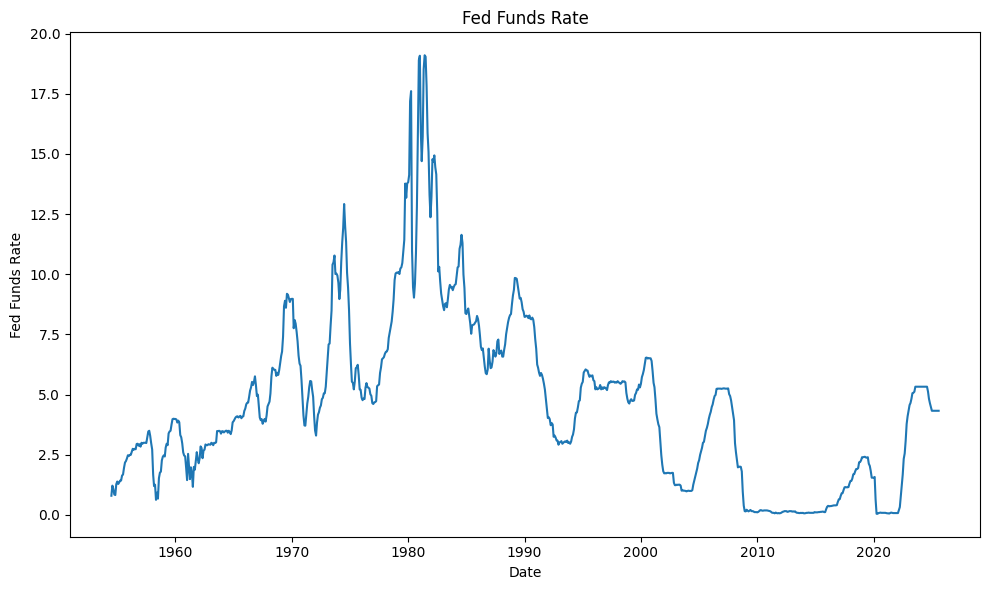

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import seaborn as sns
import fredapi.fred as fr
import pandas as pd
import fredapi as fr
from sklearn.preprocessing import MinMaxScaler
import numpy as np
from sklearn.metrics import r2_score,root_mean_squared_error
from dotenv import load_dotenv
import os
load_dotenv()
FRED_API_KEY = os.getenv("FRED_API_KEY")


fred = fr.Fred(FRED_API_KEY)




device = "cuda:0" if torch.cuda.is_available() else "cpu"
print(device)

# fed funds rate

ffr = fred.get_series("FEDFUNDS")
ffr.name = "Fed Funds Rate"

data = pd.DataFrame(ffr).dropna()
data = data.reset_index()
data['Date'] = data['index']


data.drop("index",axis=1,inplace=True)


plt.figure(figsize=(10,6))
sns.lineplot(x=data['Date'],y=data['Fed Funds Rate'])
plt.title("Fed Funds Rate")
plt.tight_layout()
plt.savefig("images/fed-funds-rate")
plt.show()


In [6]:
data.head(10)

,Fed Funds Rate,Date
0,0.80,1954-07-01
1,1.22,1954-08-01
2,1.07,1954-09-01
3,0.85,1954-10-01
4,0.83,1954-11-01
5,1.28,1954-12-01
6,1.39,1955-01-01
7,1.29,1955-02-01
8,1.35,1955-03-01
9,1.43,1955-04-01


In [2]:
#training
training = data.iloc[:,0:1].values



train_split = int(len(training) * .86)
train_data = training[:train_split]
test_data = training[train_split:]
print(f' Shape of training data: {train_data.shape}')
print(f' Shape of testing data: {test_data.shape}')

scaler = MinMaxScaler()
train_data = scaler.fit_transform(train_data)
test_data = scaler.transform(test_data)

def slider(dataframe, seq_length):
    X, y = [], []
    for i in range(len(dataframe) - seq_length):
        X_ = dataframe[i:(i + seq_length)]
        y_ = dataframe[i + seq_length]
        X.append(X_)
        y.append(y_)
    return np.array(X), np.array(y)

seq_length = 1

X_train, y_train = slider(train_data, seq_length)
X_test,y_test = slider(test_data,seq_length)


X_train = torch.from_numpy(X_train).float()
y_train = torch.from_numpy(y_train).float()

X_test = torch.from_numpy(X_test).float()
y_test = torch.from_numpy(y_test).float()



class BiLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(BiLSTM, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.output_size = output_size
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hidden_size * 2, output_size)

    def forward(self, X):
        h0 = torch.zeros(2 * self.num_layers, X.size(0), self.hidden_size)
        c0 = torch.zeros(2 * self.num_layers, X.size(0), self.hidden_size)
        out, _ = self.lstm(X,(h0, c0))
        out = self.fc(out[:,-1,:])
        return out



bidirectional_lstm = BiLSTM(input_size=1,hidden_size=256,num_layers=2,output_size=1)
epochs = 500
learning_rate = 0.001
bilistm_optimizer = torch.optim.Adam(params=bidirectional_lstm.parameters(),lr=learning_rate)
loss_fn = nn.MSELoss()

 Shape of training data: (734, 1)
 Shape of testing data: (120, 1)


In [3]:
for epoch in range(epochs):
    y_pred = bidirectional_lstm(X_train)
    loss = loss_fn(y_pred.float(),y_train)
    bilistm_optimizer.zero_grad()
    loss.backward()
    bilistm_optimizer.step()
    if epoch % 1 != 0:
        continue
    bidirectional_lstm.eval()
    with torch.no_grad():
        y_pred = bidirectional_lstm(X_train)
        train_rsme = np.sqrt(loss_fn(y_pred,y_train))
        y_pred_test =  bidirectional_lstm(X_test)
        test_rsme = np.sqrt(loss_fn(y_pred_test,y_test))
        print(f'Epoch: {epoch}; train_RSEM: {train_rsme:.4}; Test RSME: {test_rsme:.4}')
        

/tmp/ipykernel_13587/3037039946.py:12: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  train_rsme = np.sqrt(loss_fn(y_pred,y_train))
/tmp/ipykernel_13587/3037039946.py:14: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  test_rsme = np.sqrt(loss_fn(y_pred_test,y_test))


Epoch: 0; train_RSEM: 0.3255; Test RSME: 0.1498
Epoch: 1; train_RSEM: 0.3009; Test RSME: 0.129
Epoch: 2; train_RSEM: 0.2765; Test RSME: 0.1117
Epoch: 3; train_RSEM: 0.2523; Test RSME: 0.1006
Epoch: 4; train_RSEM: 0.2291; Test RSME: 0.09942
Epoch: 5; train_RSEM: 0.2079; Test RSME: 0.1103
Epoch: 6; train_RSEM: 0.1907; Test RSME: 0.1321
Epoch: 7; train_RSEM: 0.1803; Test RSME: 0.1613
Epoch: 8; train_RSEM: 0.1789; Test RSME: 0.194
Epoch: 9; train_RSEM: 0.1854; Test RSME: 0.2252
Epoch: 10; train_RSEM: 0.1945; Test RSME: 0.2491
Epoch: 11; train_RSEM: 0.2007; Test RSME: 0.2622
Epoch: 12; train_RSEM: 0.2016; Test RSME: 0.2645
Epoch: 13; train_RSEM: 0.1977; Test RSME: 0.2583
Epoch: 14; train_RSEM: 0.1908; Test RSME: 0.246
Epoch: 15; train_RSEM: 0.1828; Test RSME: 0.2301
Epoch: 16; train_RSEM: 0.1756; Test RSME: 0.2126
Epoch: 17; train_RSEM: 0.1701; Test RSME: 0.1951
Epoch: 18; train_RSEM: 0.1667; Test RSME: 0.1787
Epoch: 19; train_RSEM: 0.1652; Test RSME: 0.1643
Epoch: 20; train_RSEM: 0.165; Te

Root Mean Squared Error: 0.01
R2 Score: 99.01%


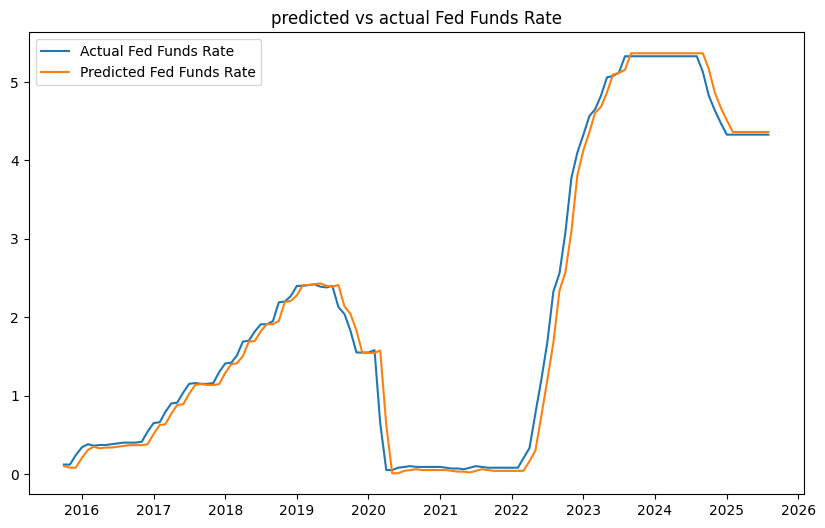

In [4]:
with torch.no_grad():
    pred = bidirectional_lstm(X_test)
    pred_np = pred.cpu().numpy()
    y_test_np = y_test.cpu().numpy()
    pred_rescaled = scaler.inverse_transform(pred_np)
    actual_rescaled = scaler.inverse_transform(y_test_np)




rmse = root_mean_squared_error(y_test_np,pred_np)
r2 = r2_score(y_test_np,pred_np)


print(f'Root Mean Squared Error: {rmse:.4}')
print(f'R2 Score: {r2*100:.2f}%')


test_dates = data.iloc[train_split + seq_length:]['Date']

comparison_df = pd.DataFrame({
    "Date": test_dates,
    "Actual Fed Funds Rate": actual_rescaled.flatten(),
    "Predicted Fed Funds Rate":pred_rescaled.flatten()
})



plt.figure(figsize=(10,6))
plt.plot(comparison_df['Date'],comparison_df["Actual Fed Funds Rate"],label="Actual Fed Funds Rate")
plt.plot(comparison_df['Date'],comparison_df['Predicted Fed Funds Rate'],label="Predicted Fed Funds Rate")
plt.title("predicted vs actual Fed Funds Rate")
plt.legend()
plt.savefig("images/Predicted-Actual-Fed-Funds-Rate.png")
plt.show()

In [5]:
print(comparison_df.head(20))
print(comparison_df.tail(20))

          Date  Actual Fed Funds Rate  Predicted Fed Funds Rate
735 2015-10-01                   0.12                  0.101384
736 2015-11-01                   0.12                  0.080849
737 2015-12-01                   0.24                  0.080849
738 2016-01-01                   0.34                  0.204033
739 2016-02-01                   0.38                  0.306643
740 2016-03-01                   0.36                  0.347676
741 2016-04-01                   0.37                  0.327161
742 2016-05-01                   0.37                  0.337419
743 2016-06-01                   0.38                  0.337419
744 2016-07-01                   0.39                  0.347676
745 2016-08-01                   0.40                  0.357934
746 2016-09-01                   0.40                  0.368190
747 2016-10-01                   0.40                  0.368190
748 2016-11-01                   0.41                  0.368190
749 2016-12-01                   0.54   